In [1]:
from mlwpy import *
from helpers import *

iris = datasets.load_iris()
diabetes = datasets.load_diabetes()
digits = datasets.load_digits()

# Models, Parameters, and Hyperparameters

In [2]:
def add_three(x):
    return x + 3
add_three(10)

13

In [3]:
def make_adder(k):
    def add_k(x):
        return x + k
    return add_k

three_adder = make_adder(3) # makes a new 3 adder
three_adder(10)

13

In [4]:
five_adder = make_adder(5)
five_adder(10)

15

In [5]:
lasso = linear_model.Lasso(alpha=0.5)
lasso.fit(diabetes.data, diabetes.target)
lasso.coef_  # coeffs, weights --> params

array([  0.    ,  -0.    , 471.0387, 136.5071,  -0.    ,  -0.    ,
       -58.3195,   0.    , 408.0233,   0.    ])

In [6]:
lasso = linear_model.Lasso(alpha=2.0)
lasso.fit(diabetes.data, diabetes.target)
lasso.coef_  # coeffs, weights --> params

array([ 0.    ,  0.    , 63.7957,  0.    ,  0.    ,  0.    , -0.    ,
        0.    ,  3.6757,  0.    ])

# Tuning Hyperparameters

##### Manual Tuning

In [7]:
knn = neighbors.KNeighborsClassifier()
print(" ".join(knn.get_params().keys()))

algorithm leaf_size metric metric_params n_jobs n_neighbors p weights


In [8]:
num_neigh = [1,3,5,10,15,20]
KNC = neighbors.KNeighborsClassifier
tt = skms.validation_curve(KNC(), 
                           iris.data, iris.target, 
                           param_name='n_neighbors',
                           param_range=num_neigh,
                           cv=5)

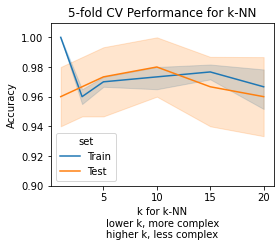

In [9]:
tidy_df = sk_graph_to_tidy(tt, num_neigh, 'k', 5)
ax = sns.lineplot(data=tidy_df, x='k', y='score', 
                  hue='set')

ax.set_title('5-fold CV Performance for k-NN')
ax.set_xlabel("\n".join(['k for k-NN',
                         'lower k, more complex',
                         'higher k, less complex']))
ax.set_ylim(.9, 1.01)
ax.set_ylabel('Accuracy');

##### Support for Tuning

In [10]:
param_grid = {"n_neighbors" : [1,3,5,10,20]}

knn = neighbors.KNeighborsClassifier()
# warning! this is with accuracy
grid_model = skms.GridSearchCV(knn,
                               return_train_score=True,
                               param_grid = param_grid, 
                               cv=10)

grid_model.fit(digits.data, digits.target)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 10, 20]},
             return_train_score=True)

In [11]:
param_cols = ['param_n_neighbors']
score_cols = ['mean_train_score', 'std_train_score',
              'mean_test_score', 'std_test_score']

# look at first five params with head()
df = pd.DataFrame(grid_model.cv_results_).head()

display(df[param_cols + score_cols])

,param_n_neighbors,mean_train_score,std_train_score,mean_test_score,std_test_score
0,1,1.0000,0.0000,0.9750,0.0171
1,3,0.9933,0.0008,0.9766,0.0155
2,5,0.9905,0.0006,0.9711,0.0172
3,10,0.9858,0.0013,0.9622,0.0205
4,20,0.9807,0.0017,0.9588,0.0224


In [12]:
grid_df = pd.DataFrame(grid_model.cv_results_, 
                       columns=['param_n_neighbors',
                                'mean_train_score',
                                'mean_test_score'])
grid_df.set_index('param_n_neighbors', inplace=True)
display(grid_df)

,mean_train_score,mean_test_score
param_n_neighbors,,
1,1.0000,0.9750
3,0.9933,0.9766
5,0.9905,0.9711
10,0.9858,0.9622
20,0.9807,0.9588


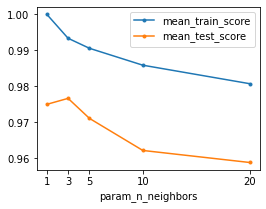

In [13]:
ax = grid_df.plot.line(marker='.')
ax.set_xticks(grid_df.index);

In [14]:
# this cell is pseudo-code, it won't run
def best_model_hyper_params(make_a_model,
                            some_hyper_params,
                            data):
    results = {}
    for hyper_params in it.combinations(some_hyper_params):
        for train, test in make_cv_split(data):
            model = make_a_model(*hyper_params).fit(train)
            # update results with current score
    
    best_hp = max(results, key=results.get)
    best_model = make_a_model(*best_hp).fit(data)
    return best_model

def do_it():
    model = pick_a_model # e.g., kNN

    some_hyper_params = [values_for_hyper_param_1, # e.g., n_neighbors=[]
                         values_for_hyper_param_2,
                         values_for_hyper_param_3]

    best_model_hyper_params(model_type, 
                            some_hyper_params, 
                            data)

In [15]:
param_grid = {"n_neighbors" : np.arange(1,11),
              "weights"     : ['uniform', 'distance'],
              "p"           : [1,2,4,8,16]}

knn = neighbors.KNeighborsClassifier()
grid_model = skms.GridSearchCV(knn, param_grid = param_grid, cv=10)

In [16]:
%timeit -r1 grid_model.fit(iris.data, iris.target)

1.35 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [17]:
param_df = pd.DataFrame.from_records(grid_model.cv_results_['params'])
param_df['mean_test_score'] = grid_model.cv_results_['mean_test_score']
param_df.sort_values(by=['mean_test_score']).tail()

,n_neighbors,p,weights,mean_test_score
75,8,4,distance,0.9800
74,8,4,uniform,0.9800
98,10,16,uniform,0.9800
88,9,16,uniform,0.9800
99,10,16,distance,0.9800


In [18]:
print("Best Estimator:", grid_model.best_estimator_,
      "Best Score:",     grid_model.best_score_,
      "Best Params:",    grid_model.best_params_, sep="\n")

Best Estimator:
KNeighborsClassifier(n_neighbors=8, p=4)
Best Score:
0.9800000000000001
Best Params:
{'n_neighbors': 8, 'p': 4, 'weights': 'uniform'}


##### Randomized Search

In [19]:
import scipy.stats as ss
knn = neighbors.KNeighborsClassifier()
param_dists = {"n_neighbors" : ss.randint(1,11), # values [1,10]
               "weights"     : ['uniform', 'distance'],
               "p"           : ss.geom(p=.5)}

mod = skms.RandomizedSearchCV(knn, 
                              param_distributions = param_dists,
                              cv=10, 
                              n_iter=20) # how many times do we sample?

# fitting 20 models
%timeit -r1 mod.fit(iris.data, iris.target)
print(mod.best_score_)

260 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
0.9800000000000001


# Nested Cross-Validation

In [20]:
param_grid = {"n_neighbors" : np.arange(1,11),
              "weights"     : ['uniform', 'distance'],
              "p"           : [1,2,4,8,16]}

knn = neighbors.KNeighborsClassifier()
grid_knn = skms.GridSearchCV(knn, 
                             param_grid = param_grid, 
                             cv=3)

In [21]:
outer_scores = skms.cross_val_score(grid_knn, 
                                    iris.data, iris.target,
                                    cv=5)
print(outer_scores)

[0.9667 1.     0.9333 0.9667 1.    ]


In [22]:
def nested_cv_pseudo_code(all_data, modelClass):
    results = []
    for outer_train, test in make_cv_split(all_data):

        for hyper_params in hyper_paramater_possibilities:
            model = modelClass(hyper_params)
            for train, valid in make_cv_split(outer_train):
                inner_score = evaluate(model.fit(train).predict(valid))
                # record inner results
        # choose model with best inner_score
        preds = best_model.fit(outer_train).predict(test)
        results.append(evaluate(preds))

In [23]:
# in practice, doing this isn't too difficult
# here's a quick 5x2 setup (2 is the inner)
param_grid = {"n_neighbors" : np.arange(1,11),
              "weights"     : ['uniform', 'distance'],
              "p"           : [1,2,4,8,16]}

knn = neighbors.KNeighborsClassifier()
grid_knn = skms.GridSearchCV(knn, param_grid, cv=2)
outer_scores = skms.cross_val_score(grid_knn,
                                    iris.data, 
                                    iris.target,
                                    cv=5)
print(outer_scores)

[0.9667 0.9667 0.9333 0.9667 1.    ]


In [24]:
grid_knn.fit(iris.data, iris.target)
preferred_params = grid_knn.best_estimator_.get_params()

final_knn = neighbors.KNeighborsClassifier(**preferred_params)
final_knn.fit(iris.data, iris.target)

KNeighborsClassifier(n_neighbors=7, p=4, weights='distance')

# Pipelines

##### A Simple Pipeline

In [25]:
scaler = skpre.StandardScaler()
logreg = linear_model.LogisticRegression()

pipe = pipeline.make_pipeline(scaler, logreg)
print(skms.cross_val_score(pipe, iris.data, iris.target, cv=10))

[1.     0.9333 1.     1.     0.9333 0.9333 0.8    1.     1.     1.    ]


In [26]:
pipe.named_steps.keys()

dict_keys(['standardscaler', 'logisticregression'])

In [27]:
pipe = pipeline.Pipeline(steps=[('scaler', scaler),
                                ('knn', knn)])

cv_scores = skms.cross_val_score(pipe, iris.data, iris.target, 
                                 cv=10, 
                                 n_jobs=-1) # all CPUs
print(pipe.named_steps.keys())
print(cv_scores)

dict_keys(['scaler', 'knn'])
[1.     0.9333 1.     0.9333 0.8667 0.9333 0.8667 1.     1.     1.    ]


##### More Complex Pipeline

In [28]:
from sklearn.base import TransformerMixin
class Median_Big_Small(TransformerMixin):
    def fit(self, ftrs, tgt=None):
        self.medians = np.median(ftrs)
        return self
    def transform(self, ftrs, tgt=None):
        return ftrs > self.medians

In [29]:
scaler = skpre.StandardScaler()
quad_inters = skpre.PolynomialFeatures(degree=2,              
                                       interaction_only=True, 
                                       include_bias=False)
median_big_small = Median_Big_Small()
knn = neighbors.KNeighborsClassifier()

pipe = pipeline.Pipeline(steps=[('scaler', scaler),
                                ('inter',  quad_inters),
                                ('mbs',    median_big_small),
                                ('knn',    knn)])

cv_scores = skms.cross_val_score(pipe, iris.data, iris.target, cv=10)

print(cv_scores)

[0.6    0.6667 0.8    0.7333 0.8    0.6667 0.6667 0.6667 0.8667 0.8   ]


# Tuning Pipelines

In [30]:
# create pipeline components and pipeline
scaler = skpre.StandardScaler()
poly   = skpre.PolynomialFeatures()
lasso  = linear_model.Lasso(selection='random', tol=.01)
pipe = pipeline.make_pipeline(scaler, 
                              poly, 
                              lasso)

In [31]:
# specified hyper-parameters to compare
param_grid = {"polynomialfeatures__degree" : np.arange(2,6),
              "lasso__alpha" : np.logspace(1,6,6,base=2)}

from pprint import pprint as pp
pp(param_grid)

{'lasso__alpha': array([ 2.,  4.,  8., 16., 32., 64.]),
 'polynomialfeatures__degree': array([2, 3, 4, 5])}


In [32]:
mod = skms.GridSearchCV(pipe, param_grid, n_jobs=-1)
mod.fit(diabetes.data, diabetes.target);

In [33]:
pp(mod.best_params_)

{'lasso__alpha': 4.0, 'polynomialfeatures__degree': 2}
